
# Data and computations for paper 

Lars G. Johnsen
National Library of Norway

In [1]:
import dhlab.nbtext as nb
import dhlab.module_update as mu
mu.update('collocations')
from collocations import dist_coll_urn, urn_coll, calculate_midpoint, dist
import pandas as pd

Updated file `D:\documents\GitHub\newspapers_coll_conc\collocations.py`

In [2]:
def df_jaccard(df, col1, col2, number=100, asc=False):
    s1 = df.sort_values(by=col1, ascending=asc)[:number].index
    s2 = df.sort_values(by=col2, ascending=asc)[:number].index
    
    #print(len(set(s1)&set(s2)))
    
    return jaccard(s1, s2)

In [3]:
def jaccards(s1, s2):
    return len(set(s1)&set(s2)),len(set(s1)|set(s2))

In [4]:
def jaccard(s1, s2):
    return len(set(s1)&set(s2))/len(set(s1)|set(s2))

In [5]:
def large_corpus_dist_coll(collword, urns = None, after= 10, before = 0, n = 300):
    colls_freq = []
    colls_dist = []
    coll = pd.DataFrame()
    for i in range(0, len(urns), n):
        a = urn_coll(collword, urns = urns[i:i + n], after= after, before = before)
        colls_freq.append(nb.frame(a['freq']))
        colls_dist.append(nb.frame(a['dist']))
    coll['freq'] = pd.concat(colls_freq, axis=1, sort=False).sum(axis=1)
    coll['dist'] = pd.concat(colls_dist, axis = 1, sort=False).mean(axis=1)
    coll['dist_score'] = round(dist(coll['dist'], calculate_midpoint(before, after), coll['freq']), 2)
    return coll

In [6]:
def large_corpus_coll(collword, urns = None, after= 5, before = 5, n = 300):
    colls = []
    for i in range(0, len(urns), n):
        colls.append(nb.urn_coll(collword, urns=urns[i:i + n], after= after, before = before))
    coll = pd.concat(colls, axis=1, sort=False).sum(axis=1)
    return pd.DataFrame(coll)

In [7]:
def make_coll_df(small, large, tot):
    """take two collocations, small and large, and a reference tot. The reference must av a column call tot as well"""
    coll = pd.DataFrame()
    coll['small'] = small['freq']
    coll['large'] = large['freq']
    #coll['ratio'] = coll['small']/coll['large']
    coll['srel'] = coll.small/coll.small.sum()
    coll['lrel'] = coll.large/coll.large.sum()
    coll['ratio'] = coll.srel/coll.lrel
    coll['adjusted'] = coll.small**0.01*coll.ratio
    coll['nb'] = coll.small/tot.tot
    return coll

### Reference corpus

The reference is the total counts from approximately 450 000 books from nb.no

In [8]:
tot = nb.frame(nb.totals(50000), 'tot')

In [9]:
nb.normalize_corpus_dataframe(tot)
tot.head()

,tot
.,0.058921
",",0.051453
og,0.025297
i,0.021425
det,0.012728


# Corpus

The corpus for doing collocations is a sample of 800 books from fictional literature, dewey decimal code 813.

In [10]:
smd = 5
lmd = 10
collword = 'kaffe'

In [11]:
def filenames(smd = smd, lmd = lmd, collword = collword, corpus_size= 1000, period = (1980, 2000)):
    return {
    'small_right': '_'.join([collword, str(smd), str(corpus_size), '-'.join([str(x) for x in period]), str(0), str(int(2*smd)), '.csv']),
    'large_right': '_'.join([collword, str(smd), str(corpus_size),  '-'.join([str(x) for x in period]), str(0), str(int(2*lmd)), '.csv']),
    'small_left' : '_'.join([collword, str(lmd), str(corpus_size),  '-'.join([str(x) for x in period]), str(int(2*smd)), str(0), '.csv']),
    'large_left' : '_'.join([collword, str(lmd), str(corpus_size),  '-'.join([str(x) for x in period]), str(int(2*lmd)), str(0), '.csv'])
        }

In [12]:
names = filenames(smd=smd, lmd=lmd, collword=collword)
names

{'small_right': 'kaffe_5_1000_1980-2000_0_10_.csv',
 'large_right': 'kaffe_5_1000_1980-2000_0_20_.csv',
 'small_left': 'kaffe_10_1000_1980-2000_10_0_.csv',
 'large_left': 'kaffe_10_1000_1980-2000_20_0_.csv'}

In [13]:
a1 = pd.read_csv(names['small_right'], index_col=0)
a2 = pd.read_csv(names['large_right'], index_col=0)
b1 = pd.read_csv(names['small_left'], index_col=0)
b2 = pd.read_csv(names['large_left'], index_col=0)

Set up the distance parameters and collword, smd is small distance while lmd is large distance. These values are half of the actual window, and used to make a normalized score, call ascore. See below.

## Create collocation dataframe 

Based on data from a1 and a2, and b1 and b2. The name for the collocations after is `coll` while `collb` is for the collocates coming before.

In [14]:
coll = make_coll_df(a1, a2, tot)
collb = make_coll_df(b1, b2, tot)

## Sorting 

Sorting on the reference is by column 'nb'

In [15]:
coll[coll.small > 1].sort_values(by='nb', ascending=False)[:20][:20].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,nb
kakao,63,70,0.00116258,0.000700511,1.65961,1.72981,2.39077e+07
drikkes,22,23,0.000405979,0.000230168,1.76384,1.81921,1.6324e+07
bananer,33,38,0.000608968,0.000380278,1.60138,1.65836,1.62159e+07
koppene,19,25,0.000350618,0.000250183,1.40145,1.44333,1.42159e+07
kaker,92,96,0.00169773,0.000960701,1.76718,1.84892,1.38605e+07
rundstykker,14,17,0.00025835,0.000170124,1.5186,1.55921,1.34513e+07
vafler,13,15,0.000239897,0.00015011,1.59814,1.63967,1.17224e+07
konjakk,37,40,0.000682783,0.000400292,1.70571,1.76843,1.10812e+07
kannen,11,11,0.000202989,0.00011008,1.84401,1.88876,1.07374e+07
Kaffen,10,22,0.000184536,0.000220161,0.838187,0.857711,9.80764e+06


In [16]:
coll[coll.small < coll.large].sort_values(by='adjusted', ascending=False)[:20].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,nb
kaker,92,96,0.00169773,0.000960701,1.76718,1.84892,1.38605e+07
drikkes,22,23,0.000405979,0.000230168,1.76384,1.81921,1.6324e+07
kake,19,20,0.000350618,0.000200146,1.75181,1.80416,2.12312e+06
tømmer,15,16,0.000276804,0.000160117,1.72876,1.77622,1.10495e+06
bomull,50,54,0.000922679,0.000540394,1.70742,1.77554,9.39681e+06
smørbrød,26,28,0.000479793,0.000280205,1.7123,1.769,7.99627e+06
konjakk,37,40,0.000682783,0.000400292,1.70571,1.76843,1.10812e+07
krydder,14,15,0.00025835,0.00015011,1.72108,1.7671,2.76066e+06
mineralvann,13,14,0.000239897,0.000140102,1.7123,1.75678,9.23484e+06
senga,13,14,0.000239897,0.000140102,1.7123,1.75678,823880


In [17]:
coll[coll.small < coll.large].sort_values(by='ratio', ascending=False)[:20].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,nb
kaker,92,96,0.00169773,0.000960701,1.76718,1.84892,1.38605e+07
drikkes,22,23,0.000405979,0.000230168,1.76384,1.81921,1.6324e+07
kake,19,20,0.000350618,0.000200146,1.75181,1.80416,2.12312e+06
tømmer,15,16,0.000276804,0.000160117,1.72876,1.77622,1.10495e+06
krydder,14,15,0.00025835,0.00015011,1.72108,1.7671,2.76066e+06
mineralvann,13,14,0.000239897,0.000140102,1.7123,1.75678,9.23484e+06
smørbrød,26,28,0.000479793,0.000280205,1.7123,1.769,7.99627e+06
senga,13,14,0.000239897,0.000140102,1.7123,1.75678,823880
bomull,50,54,0.000922679,0.000540394,1.70742,1.77554,9.39681e+06
konjakk,37,40,0.000682783,0.000400292,1.70571,1.76843,1.10812e+07


In [18]:
coll.loc[[',','.', 'og','eller', 'i', 'på']]

,small,large,srel,lrel,ratio,adjusted,nb
",",3215.0,5612.0,0.059328,0.056161,1.056397,1.145246,62483.801541
.,3964.0,7216.0,0.073150,0.072213,1.012980,1.100480,67276.426308
og,2753.0,4318.0,0.050803,0.043212,1.175675,1.272581,108825.065221
eller,215.0,341.0,0.003968,0.003412,1.162647,1.226795,78311.061755
i,980.0,1964.0,0.018085,0.019654,0.920128,0.985736,45740.823258
på,847.0,1607.0,0.015630,0.016082,0.971922,1.039705,88329.235686


# collb

In [19]:
collb[collb.small < collb.large].sort_values(by='adjusted', ascending=False)[:40].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,nb
skjenket,163,166,0.00300794,0.00166685,1.80456,1.89886,1.90461e+07
drakk,326,336,0.00601587,0.00337387,1.78308,1.88931,1.17218e+07
kopp,850,886,0.0156856,0.00889656,1.7631,1.88613,6.06607e+07
kanne,58,61,0.00107031,0.000612517,1.74739,1.8198,3.15124e+07
rykende,37,39,0.000682783,0.00039161,1.74353,1.80764,1.39673e+07
helte,35,37,0.000645876,0.000371527,1.73844,1.80135,6.41255e+06
slurk,49,52,0.000904226,0.000522146,1.73175,1.80047,6.4292e+06
serverer,19,20,0.000350618,0.000200825,1.74589,1.79806,7.51259e+06
sterk,85,91,0.00156856,0.000913756,1.7166,1.79458,857145
svart,107,115,0.00197453,0.00115475,1.70993,1.79173,1.73509e+06


In [20]:
collb.sort_values(by='nb', ascending=False)[:40].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,nb
kopp,850,886,0.0156856,0.00889656,1.7631,1.88613,6.06607e+07
kanne,58,61,0.00107031,0.000612517,1.74739,1.8198,3.15124e+07
skjenket,163,166,0.00300794,0.00166685,1.80456,1.89886,1.90461e+07
mineralvann,25,27,0.00046134,0.000271114,1.70164,1.75731,1.77593e+07
rykende,37,39,0.000682783,0.00039161,1.74353,1.80764,1.39673e+07
Viktigste,25,58,0.00046134,0.000582394,0.792144,0.818057,1.38249e+07
kakao,35,44,0.000645876,0.000441816,1.46187,1.51478,1.32821e+07
serverte,43,47,0.000793504,0.00047194,1.68137,1.74581,1.30442e+07
kopper,87,106,0.00160546,0.00106437,1.50836,1.57725,1.19618e+07
vafler,13,15,0.000239897,0.000150619,1.59274,1.63412,1.17224e+07


In [21]:
collb.sort_values(by='nb', ascending=False).loc[['sterk', 'kruttsterk']].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,nb
sterk,85,91,0.00156856,0.000913756,1.7166,1.79458,857145
kruttsterk,7,8,0.000129175,8.03302e-05,1.60805,1.63965,0


# coll

In [22]:
coll[coll.small < coll.large].sort_values(by='ratio', ascending=False)[:30].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,nb
kaker,92,96,0.00169773,0.000960701,1.76718,1.84892,1.38605e+07
drikkes,22,23,0.000405979,0.000230168,1.76384,1.81921,1.6324e+07
kake,19,20,0.000350618,0.000200146,1.75181,1.80416,2.12312e+06
tømmer,15,16,0.000276804,0.000160117,1.72876,1.77622,1.10495e+06
krydder,14,15,0.00025835,0.00015011,1.72108,1.7671,2.76066e+06
mineralvann,13,14,0.000239897,0.000140102,1.7123,1.75678,9.23484e+06
smørbrød,26,28,0.000479793,0.000280205,1.7123,1.769,7.99627e+06
senga,13,14,0.000239897,0.000140102,1.7123,1.75678,823880
bomull,50,54,0.000922679,0.000540394,1.70742,1.77554,9.39681e+06
konjakk,37,40,0.000682783,0.000400292,1.70571,1.76843,1.10812e+07


In [23]:
coll.sort_values(by='nb', ascending=False)[:30].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,nb
kakao,63,70,0.00116258,0.000700511,1.65961,1.72981,2.39077e+07
drikkes,22,23,0.000405979,0.000230168,1.76384,1.81921,1.6324e+07
bananer,33,38,0.000608968,0.000380278,1.60138,1.65836,1.62159e+07
koppene,19,25,0.000350618,0.000250183,1.40145,1.44333,1.42159e+07
kaker,92,96,0.00169773,0.000960701,1.76718,1.84892,1.38605e+07
rundstykker,14,17,0.00025835,0.000170124,1.5186,1.55921,1.34513e+07
vafler,13,15,0.000239897,0.00015011,1.59814,1.63967,1.17224e+07
konjakk,37,40,0.000682783,0.000400292,1.70571,1.76843,1.10812e+07
kannen,11,11,0.000202989,0.00011008,1.84401,1.88876,1.07374e+07
Kaffen,10,22,0.000184536,0.000220161,0.838187,0.857711,9.80764e+06


# jaccard similarity

compare over a range

In [24]:
rng = range(2,40,2)

# for collb

In [25]:
jaccard_scoresb = nb.frame({'ratio': {x:df_jaccard(collb[collb.small < collb.large], 'nb', 'adjusted', x) for x in rng},
                            'srel': {x:df_jaccard(collb[collb.small < collb.large], 'nb', 'srel', x) for x in rng},
                           'lrel': {x:df_jaccard(collb[collb.small < collb.large], 'nb', 'lrel', x) for x in rng}
                          }).transpose()

Text(0, 0.5, 'Jaccard score')

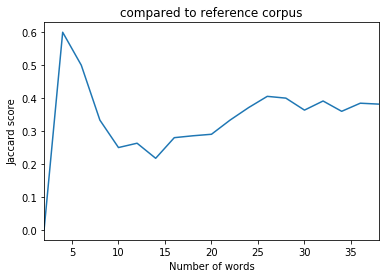

In [26]:
ax = jaccard_scoresb['ratio'].plot(title='compared to reference corpus');
ax.set_xlabel("Number of words")
ax.set_ylabel("Jaccard score")

# for coll

In [27]:
jaccard_scores = nb.frame({'ratio': {x:df_jaccard(coll[coll.small < coll.large], 'nb', 'adjusted', x) for x in rng},
                            'srel': {x:df_jaccard(coll[coll.small < coll.large], 'nb', 'srel', x) for x in rng},
                           'lrel': {x:df_jaccard(coll[coll.small < coll.large], 'nb', 'lrel', x) for x in rng}
                          }).transpose()

Text(0, 0.5, 'Jaccard score')

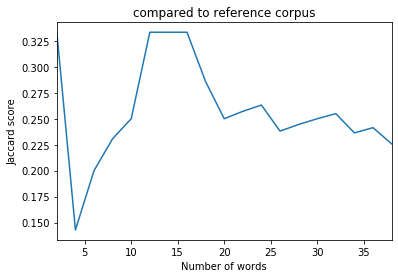

In [28]:
ax = jaccard_scores['ratio'].plot(title='compared to reference corpus');
ax.set_xlabel("Number of words")
ax.set_ylabel("Jaccard score")

In [29]:
jaccards(collb[collb.small < collb.large].sort_values(by='ratio', ascending = False)[:60].index, collb.sort_values(by='nb', ascending=False)[:100].index)

(26, 134)